## Classifying movie reviews : A binary classification example

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from warnings import filterwarnings
filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
tf.__version__

'2.6.0'

In [3]:
(trainInputs, trainTarget), (testInputs, testTarget) = imdb.load_data(num_words = 10000)

In [4]:
# trainInputs[0]
trainTarget[0]

1

In [5]:
max(max(sequence) for sequence in trainInputs)

9999

For kicks, here’s how you can quickly decode one of these reviews back to English
words:

In [6]:
wordIndex = imdb.get_word_index()
reverse_Wordindex = dict([
    (value, key) for (key, value) in wordIndex.items()
])
decodedReview = ' '.join([reverse_Wordindex.get(i - 3, '?') for i in trainInputs[0]])

In [7]:
decodedReview

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

## Peparing the data :

You can’t feed lists of integers into a neural network. You have to turn your lists into
tensors. There are two ways to do that:
- Pad your lists so that they all have the same length, turn them into an integer
tensor of shape (samples, word_indices), and then use as the first layer in
your network a layer capable of handling such integer tensors (the Embedding
layer, which we’ll cover in detail later in the book).
- One-hot encode your lists to turn them into vectors of 0s and 1s. This would
mean, for instance, turning the sequence [3, 5] into a 10,000-dimensional vector
that would be all 0s except for indices 3 and 5, which would be 1s. Then you
could use as the first layer in your network a Dense layer, capable of handling
floating-point vector data.


Let’s go with the latter solution to vectorize the data, which you’ll do manually for
maximum clarity

In [8]:
import numpy as np

# ------------------------------------------------

def vectorizeSeq(sequences, dimension = 10000) :
    result = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences) :
        result[i, sequence] = 1. 
    return result

# ------------------------------------------------

xTrainInp = vectorizeSeq(trainInputs)       # train inputs  
xTestInp = vectorizeSeq(testInputs)         # test inputs

In [9]:
print(xTrainInp[0])

[0. 1. 1. ... 0. 0. 0.]


Vectorize our target label :

In [10]:
yTrainT = np.asarray(trainTarget).astype('float32')
yTestT = np.asanyarray(testTarget).astype('float32')

## Building our neural network :

In [11]:
# -------- Model definition ---------
from tensorflow.keras import models, layers 

In [12]:
model = models.Sequential([
    layers.Dense(16, activation = "relu", input_shape = (10000, )),
    layers.Dense(16, activation = "relu"),
    layers.Dense(1, activation = "sigmoid")

])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160016    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [14]:
list(model.layers)

## Compiling the model :

In [15]:
model.compile(optimizer = 'rmsprop', 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy']
              )

You’re passing your optimizer, loss function, and metrics as strings, which is possible
because rmsprop, binary_crossentropy, and accuracy are packaged as part of Keras.
Sometimes you may want to configure the parameters of your optimizer or pass a custom
loss function or metric function. The former can be done by passing an optimizer
class instance as the optimizer argument.

the latter can be
done by passing function objects as the loss and/or metrics arguments.

## Configuring the optimizer :

In [16]:
from tensorflow.keras import optimizers

model.compile(optimizer = optimizers.RMSprop(lr = .001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy']
              )

## Using custom losses and metrics :

In [17]:
from tensorflow.keras import losses, metrics

model.compile(optimizer = optimizers.RMSprop(lr = .001), 
              loss = losses.binary_crossentropy,
              metrics = [metrics.binary_accuracy]                
             )

## Validating our approach :

In order to monitor during training the accuracy of the model on data it has never
seen before, we'll create a validation set by setting apart 10,000 samples from the
original training data.

In [18]:
xVal = xTrainInp[:10000]
partialXTrain = xTrainInp[10000:]
yVal = yTrainT[:10000]
partialyTrain = yTrainT[10000:]

In [19]:
%%capture
history = model.fit(partialXTrain, partialyTrain, epochs = 20, 
                    batch_size = 20, validation_data = (xVal, yVal))

In [20]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

The dictionary contains four entries: one per metric that was being monitored during
training and during validation. In the following two listing, let’s use Matplotlib to plot
the training and validation loss side by side as well as the training and
validation accuracy. Note that your own results may vary slightly due to
a different random initialization of your network.

## Plotting the training and validation loss :

In [21]:
import matplotlib.pyplot as plt 
%matplotlib inline 

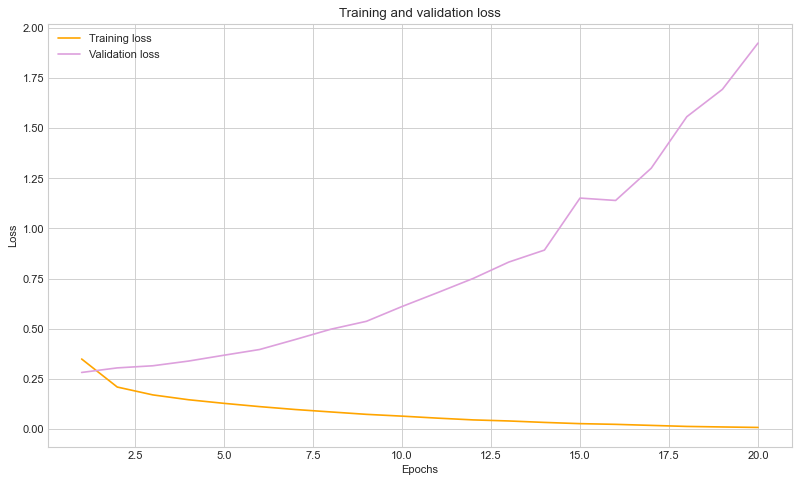

In [22]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss = history_dict['val_loss']

acc = history_dict['binary_accuracy']
epochs = range(1, len(acc) + 1)

plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (12, 7), dpi = 80)
plt.plot(epochs, loss_values, 'orange', label = 'Training loss')
plt.plot(epochs, val_loss, 'plum', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Plotting the training accuracy :

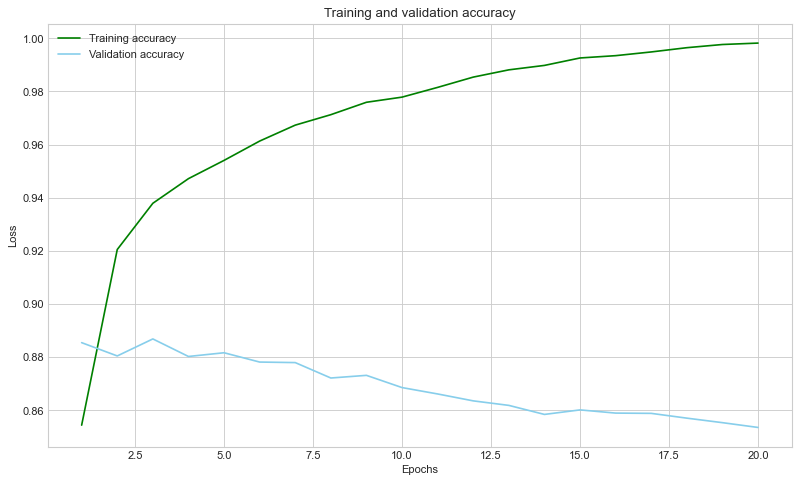

In [23]:
# plt.clf()         <<- clears the figure

acc_values = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']

plt.figure(figsize = (12, 7), dpi = 80)
plt.plot(epochs, acc_values, 'g', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'skyblue', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

As you can see, the training loss decreases with every epoch, and the training accuracy
increases with every epoch. That’s what you would expect when running gradientdescent
optimization—the quantity you’re trying to minimize should be less with
every iteration. But that isn’t the case for the validation loss and accuracy: they seem to
peak at the fourth epoch. This is an example of what we warned against earlier: a
model that performs better on the training data isn’t necessarily a model that will do
better on data it has never seen before. In precise terms, what you’re seeing is overfitting:
after the second epoch, you’re overoptimizing on the training data, and you end
up learning representations that are specific to the training data and don’t generalize
to data outside of the training set.

In this case, to prevent overfitting, you could stop training after three epochs. In
general, you can use a range of techniques to mitigate overfitting.

Let’s train a new network from scratch for four epochs and then evaluate it on the
test data.

In [24]:
%%capture
Net = models.Sequential([
      layers.Dense(16, activation = "relu", input_shape = (10000, )),
      layers.Dense(16, activation = "relu"),
      layers.Dense(1, activation = "sigmoid")
      ])

# ---------------------------------------------------------

Net.compile(optimizer = optimizers.RMSprop(lr = .001), 
            loss = losses.binary_crossentropy, 
            metrics = [metrics.binary_accuracy])

# ---------------------------------------------------------

Net.fit(xTrainInp, yTrainT, epochs = 4, batch_size = 512)
res = Net.evaluate(xTestInp, yTestT)

In [38]:
# print(res) 
# >> [0.2987891137599945, 0.8804000020027161]

for i in res :
    print(round(i, 2), end = ' % \n', ) 

0.3 % 
0.88 % 


## Using a trained network to generate predictions on new data :

In [26]:
print(Net.predict(xTestInp))

[[0.19693413]
 [0.99996996]
 [0.928337  ]
 ...
 [0.14677387]
 [0.09950625]
 [0.68554896]]
